In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = True

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 20
MIN_SIZE = 0
NUM_CORES = 24

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
SAMPLE_RATIO = 0.01

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"

In [9]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

save_parent_location = "hdfs://deka.cip.ifi.lmu.de/pg-vectors/"
if IS_SAMPLE: 
    save_parent_location = save_parent_location + "sample_" + str(SAMPLE_RATIO) + "/"


root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "sample_" + str(SAMPLE_RATIO))
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output_training_validation_documents_' + str(SAMPLE_RATIO)

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"
validation_docs_list_file = exports_location + "validation_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_sample_%s_data_preprocessed-" % str(SAMPLE_RATIO)
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_sample_%s_docids_preprocessed-" % str(SAMPLE_RATIO)
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_sample_%s_data_preprocessed-" % str(SAMPLE_RATIO)
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_sample_%s_docids_preprocessed-" % str(SAMPLE_RATIO)

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))

CPU times: user 28.5 s, sys: 2.79 s, total: 31.3 s
Wall time: 31.5 s


In [11]:
SMALL_SAMPLE_RATIO = 0.0001

validation_small_preprocessed_files_prefix = root_location + "validation_docs_sample_%s_data_preprocessed-" % str(SMALL_SAMPLE_RATIO)
validation_small_preprocessed_docids_files_prefix = root_location + "validation_docs_sample_%s_docids_preprocessed-" % str(SMALL_SAMPLE_RATIO)

validation_small_docs_list_file = exports_location + "validation_documents_" + str(SMALL_SAMPLE_RATIO) + "_sample.pkl"
validation_small_docs_list = pickle.load(open(validation_small_docs_list_file))

In [12]:
len(training_docs_list)

49789

In [13]:
len(validation_docs_list)

12412

In [14]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [15]:
def get_training_vector(classification, term_list, classifications, number_of_terms):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))

def train_level_new(docs_index, classification, doc_classification_map, number_of_terms):
    training_vectors = docs_index.map(
        lambda (doc_id, postings): get_training_vector(classification, postings,
                                                        doc_classification_map[doc_id], number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

def model_exists(path):
    try:
        model = SVMModel.load(sc, path)
        return True;
    except:
        return False
    
def get_training_vector(classification, dense_vector, classifications):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, dense_vector)

def train_level_doc2vec(classification, doc_classification_map):
    doc2vec_model = GLOBAL_VARS.DOC2VEC_MODEL
    training_vectors = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_vectors.append(get_training_vector(classification, normal_array, 
                                                    doc_classification_map[doc_id]))
    info("Finished getting training vectors")
    training_vectors = sc.parallelize(training_vectors)
    info("Finished parallelization")
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

In [16]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [17]:
def train_classifications(classifications):
    info("====== Doing Training")
    i=0
    for classification in classifications:
        print classification
        try:
            model_path = get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification)
            if not model_exists(model_path):
                training_vectors, svm = train_level_doc2vec(classification, doc_classification_map)
                svm.save(sc, model_path)
            else:
                print "Model Exists"
        except:
            print "Problem creating: %s: %s" % (classification, GLOBAL_VARS.MODEL_NAME)
            raise

In [18]:
def do_validation(validation_vectors_matrix, doc_classification_map, classifications, classifications_name):

    info("====== Doing Validation")
    method = GLOBAL_VARS.MODEL_NAME
    subset = classifications_name

    doc_count = validation_vectors_matrix.shape[0]
    y_score = np.zeros((doc_count, len(classifications)))
    y_true = np.zeros((doc_count, len(classifications)))
    i=0

    for classification in classifications:
        print classification

        validation_vectors = get_validation_doc2vec_spark_vectors(validation_vectors_matrix, 
                                                                  classification, doc_classification_map)
        #global binarySvm
        binarySvm = SVMModel.load(sc, get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification))
        info("Loaded the model, Doing the prediction now....")
        binarySvm.clearThreshold()
        binarySvmB = sc.broadcast(binarySvm)
        # using the broadcasted binarySvm variable, fixes global name 'binarySvm' is not defined as this variable was not
        # available in the workers, so we pass it explicitly to the mapper using partial
        labels_predictions = validation_vectors.map( \
            partial(lambda svm, p: (p.label, svm.value.predict(p.features)), binarySvmB) \
        ).collect()
        #labels = test_labeled_points.map(lambda p: p.labels)
        y_true[:,i] = [label_pred[0] for label_pred in labels_predictions]
        y_score[:,i] = [label_pred[1] for label_pred in labels_predictions]
        i+=1
    y_binary_score = get_binary(y_score)
    # results[method]["y_true"] = y_true
    # results[method]["y_score"] = y_score
    # results[method]["y_binary_score"] = y_binary_score
    metrics = get_metrics(y_true, y_score, y_binary_score)
    return metrics


In [19]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [20]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [21]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

In [22]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    training_data = []
    training_labels = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_data.append(normal_array)
        eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
        training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
    training_labels = np.array(training_labels)
    return training_data, training_labels

In [23]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

#### Get starting positions in bytes for every line to be able to do random sampling

In [26]:
%%time
line_positions = dict()
with open(training_file) as f:
    
    i = 0
    line_positions[i] = f.tell()
    line = f.readline()
    while line:
        i+=1
        if not line.strip(): continue
        line_positions[i] = f.tell()
        line = f.readline()
    del line_positions[i]

CPU times: user 6.62 s, sys: 592 ms, total: 7.22 s
Wall time: 7.21 s


### Doc2vec and SVM Parameters

In [40]:
DOC2VEC_SIZE = 500
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 1000 # report the progress every x terms

In [41]:
SVM_ITERATIONS = 100
SVM_CONVERGENCE = 0.001
SVM_REG = 0.01
SVM_CLASS_WEIGHTS = 'balanced'
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

In [31]:
NN_HIDDEN_NEURONS = 4500
NN_EPOCHS = 50

In [32]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

## Create the Doc2vec model

In [42]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [43]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [44]:
%%time
training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2017-01-01 16:17:05,569 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model
2017-01-01 16:17:06,468 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.docvecs.* with mmap=None
2017-01-01 16:17:06,470 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-01 16:17:06,858 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.syn1neg.npy with mmap=None
2017-01-01 16:17:08,271 : INFO : loading syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.syn0.npy with mmap=None
2017-01-01 16:17:08,824 : INFO : setting ignored attribute syn0norm to None
2017-01-01 16:17:08,825 : INFO : setting ignored attribute cum_table to None
2017-01-01 16:17:09,331 : INFO : rese

CPU times: user 8.4 s, sys: 752 ms, total: 9.15 s
Wall time: 11.1 s


In [45]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [46]:
doc2vec_model.min_alpha = 0.025
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'

In [47]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

<IPython.core.display.Javascript object>


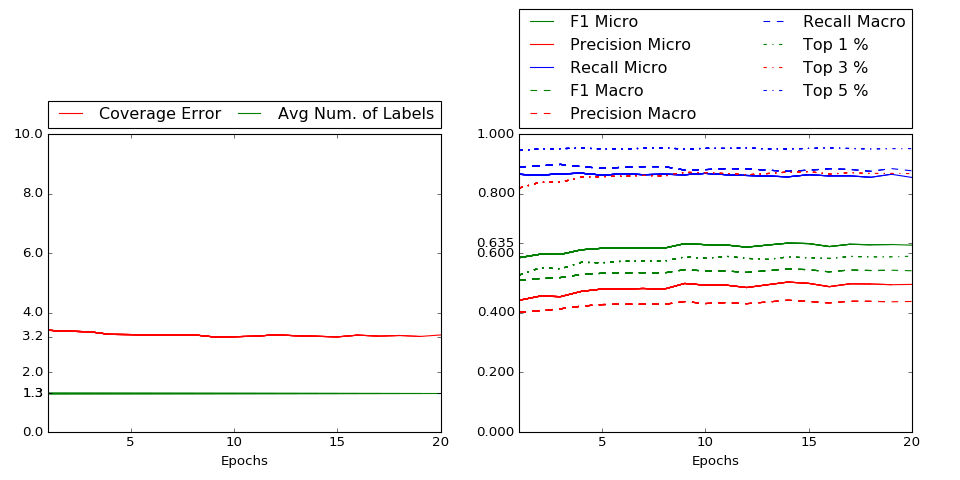

2017-01-01 16:17:21,847 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-01-01 16:17:21,848 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 16:17:21,849 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 16:17:21,860 : INFO : Loading new batch for index: 0
2017-01-01 16:17:36,386 : INFO : Finished loading new batch
2017-01-01 16:17:36,732 : INFO : PROGRESS: at 0.00% examples, 153 words/s, in_qsize 47, out_qsize 0
2017-01-01 16:17:56,732 : INFO : PROGRESS: at 2.30% examples, 184268 words/s, in_qsize 48, out_qsize 0
2017-01-01 16:18:16,764 : INFO : PROGRESS: at 5.04% examples, 254530 words/s, in_qsize 46, out_qsize 8
2017-01-01 16:18:36,771 : INFO : PROGRESS: at 8.03% examples, 297085 words/s, in_qsize 47, out_qsize 0
2017-01-01 16:18:56,7

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 16:38:05,989 : INFO : Getting Validation Embeddings
2017-01-01 16:38:05,994 : INFO : ===== Getting validation vectors with inference
2017-01-01 16:38:06,004 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.582, Avg Labels: 1.290, 
		 Top 1: 0.543, Top 3: 0.804, Top 5: 0.933, 
		 F1 Micro: 0.576, Total Pos: 119,478


2017-01-01 16:38:17,392 : INFO : Finished loading new batch
2017-01-01 16:38:47,744 : INFO : Finished: 999
2017-01-01 16:39:17,543 : INFO : Finished: 1999
2017-01-01 16:39:46,213 : INFO : Finished: 2999
2017-01-01 16:40:14,267 : INFO : Finished: 3999
2017-01-01 16:40:43,372 : INFO : Finished: 4999
2017-01-01 16:41:12,359 : INFO : Finished: 5999
2017-01-01 16:41:39,891 : INFO : Finished: 6999
2017-01-01 16:42:07,685 : INFO : Finished: 7999
2017-01-01 16:42:36,311 : INFO : Finished: 8999
2017-01-01 16:43:04,400 : INFO : Finished: 9999
2017-01-01 16:43:06,790 : INFO : Loading new batch for index: 10000
2017-01-01 16:43:09,653 : INFO : Finished loading new batch
2017-01-01 16:43:38,731 : INFO : Finished: 10999
2017-01-01 16:44:07,149 : INFO : Finished: 11999
2017-01-01 16:44:07,580 : INFO : Loading new batch for index: 12412
2017-01-01 16:44:07,583 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 16:44:20,323 : INFO : Finished: 12412
2017-01-01 16:44:20,326 : INFO : Fin

[[0 1 0 ..., 1 1 0]
 [0 1 1 ..., 0 0 1]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.418, Avg Labels: 1.300, 
		 Top 1: 0.527, Top 3: 0.820, Top 5: 0.946, 
		 F1 Micro: 0.586, Total Pos: 31,474


/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))
2017-01-01 16:44:28,996 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-01-01 16:44:29,002 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 16:44:29,004 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 16:44:29,018 : INFO : Loading new batch for index: 0
2017-01-01 16:44:38,719 : INFO : Finished loading new batch
2017-01-01 16:44:39,328 : INFO : PROGRESS: at 0.00% examples, 646 words/s, in_qsize 47, out_qsize 0
2017-01-01 16:44:59,356 : INFO : PROGRESS: at 2.90% exa

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 17:04:53,402 : INFO : Getting Validation Embeddings
2017-01-01 17:04:53,406 : INFO : ===== Getting validation vectors with inference
2017-01-01 17:04:53,422 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.342, Avg Labels: 1.290, 
		 Top 1: 0.580, Top 3: 0.852, Top 5: 0.946, 
		 F1 Micro: 0.613, Total Pos: 112,862


2017-01-01 17:05:03,479 : INFO : Finished loading new batch
2017-01-01 17:05:33,826 : INFO : Finished: 999
2017-01-01 17:06:03,730 : INFO : Finished: 1999
2017-01-01 17:06:32,630 : INFO : Finished: 2999
2017-01-01 17:07:01,110 : INFO : Finished: 3999
2017-01-01 17:07:30,491 : INFO : Finished: 4999
2017-01-01 17:07:59,843 : INFO : Finished: 5999
2017-01-01 17:08:28,146 : INFO : Finished: 6999
2017-01-01 17:08:56,334 : INFO : Finished: 7999
2017-01-01 17:09:25,317 : INFO : Finished: 8999
2017-01-01 17:09:53,757 : INFO : Finished: 9999
2017-01-01 17:09:56,246 : INFO : Loading new batch for index: 10000
2017-01-01 17:09:58,509 : INFO : Finished loading new batch
2017-01-01 17:10:27,818 : INFO : Finished: 10999
2017-01-01 17:10:56,613 : INFO : Finished: 11999
2017-01-01 17:10:57,031 : INFO : Loading new batch for index: 12412
2017-01-01 17:10:57,034 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 17:11:09,779 : INFO : Finished: 12412
2017-01-01 17:11:09,785 : INFO : Fin

[[0 1 0 ..., 1 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 1 1]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.384, Avg Labels: 1.300, 
		 Top 1: 0.552, Top 3: 0.839, Top 5: 0.952, 
		 F1 Micro: 0.597, Total Pos: 30,436


2017-01-01 17:11:18,601 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-01-01 17:11:18,607 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 17:11:18,609 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 17:11:18,622 : INFO : Loading new batch for index: 0
2017-01-01 17:11:28,898 : INFO : Finished loading new batch
2017-01-01 17:11:29,112 : INFO : PROGRESS: at 0.00% examples, 641 words/s, in_qsize 47, out_qsize 0
2017-01-01 17:11:49,156 : INFO : PROGRESS: at 3.25% examples, 293481 words/s, in_qsize 47, out_qsize 0
2017-01-01 17:12:09,178 : INFO : PROGRESS: at 6.43% examples, 353888 words/s, in_qsize 47, out_qsize 2
2017-01-01 17:12:29,170 : INFO : PROGRESS: at 9.73% examples, 379511 words/s, in_qsize 46, out_qsize 1
2017-01-01 17:12:49,1

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 17:31:22,928 : INFO : Getting Validation Embeddings
2017-01-01 17:31:22,933 : INFO : ===== Getting validation vectors with inference
2017-01-01 17:31:22,943 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.236, Avg Labels: 1.290, 
		 Top 1: 0.596, Top 3: 0.868, Top 5: 0.951, 
		 F1 Micro: 0.628, Total Pos: 110,566


2017-01-01 17:31:34,369 : INFO : Finished loading new batch
2017-01-01 17:32:03,477 : INFO : Finished: 999
2017-01-01 17:32:33,201 : INFO : Finished: 1999
2017-01-01 17:33:02,118 : INFO : Finished: 2999
2017-01-01 17:33:30,437 : INFO : Finished: 3999
2017-01-01 17:33:59,373 : INFO : Finished: 4999
2017-01-01 17:34:28,549 : INFO : Finished: 5999
2017-01-01 17:34:56,514 : INFO : Finished: 6999
2017-01-01 17:35:24,829 : INFO : Finished: 7999
2017-01-01 17:35:53,947 : INFO : Finished: 8999
2017-01-01 17:36:22,325 : INFO : Finished: 9999
2017-01-01 17:36:24,718 : INFO : Loading new batch for index: 10000
2017-01-01 17:36:26,818 : INFO : Finished loading new batch
2017-01-01 17:36:55,909 : INFO : Finished: 10999
2017-01-01 17:37:24,437 : INFO : Finished: 11999
2017-01-01 17:37:24,865 : INFO : Loading new batch for index: 12412
2017-01-01 17:37:24,868 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 17:37:37,597 : INFO : Finished: 12412
2017-01-01 17:37:37,599 : INFO : Fin

[[0 1 0 ..., 1 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 1 1 1]
 ..., 
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.370, Avg Labels: 1.300, 
		 Top 1: 0.548, Top 3: 0.839, Top 5: 0.952, 
		 F1 Micro: 0.597, Total Pos: 30,692


2017-01-01 17:37:46,060 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-01-01 17:37:46,064 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 17:37:46,065 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 17:37:46,091 : INFO : Loading new batch for index: 0
2017-01-01 17:37:55,632 : INFO : Finished loading new batch
2017-01-01 17:37:56,303 : INFO : PROGRESS: at 0.00% examples, 658 words/s, in_qsize 47, out_qsize 0
2017-01-01 17:38:16,327 : INFO : PROGRESS: at 3.35% examples, 305757 words/s, in_qsize 47, out_qsize 0
2017-01-01 17:38:36,330 : INFO : PROGRESS: at 6.74% examples, 371179 words/s, in_qsize 47, out_qsize 0
2017-01-01 17:38:56,354 : INFO : PROGRESS: at 10.17% examples, 398600 words/s, in_qsize 48, out_qsize 0
2017-01-01 17:39:16,

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 17:57:45,249 : INFO : Getting Validation Embeddings
2017-01-01 17:57:45,255 : INFO : ===== Getting validation vectors with inference
2017-01-01 17:57:45,266 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.201, Avg Labels: 1.290, 
		 Top 1: 0.602, Top 3: 0.873, Top 5: 0.953, 
		 F1 Micro: 0.633, Total Pos: 109,817


2017-01-01 17:57:55,079 : INFO : Finished loading new batch
2017-01-01 17:58:25,021 : INFO : Finished: 999
2017-01-01 17:58:54,513 : INFO : Finished: 1999
2017-01-01 17:59:22,994 : INFO : Finished: 2999
2017-01-01 17:59:51,084 : INFO : Finished: 3999
2017-01-01 18:00:20,199 : INFO : Finished: 4999
2017-01-01 18:00:49,278 : INFO : Finished: 5999
2017-01-01 18:01:17,315 : INFO : Finished: 6999
2017-01-01 18:01:45,476 : INFO : Finished: 7999
2017-01-01 18:02:14,631 : INFO : Finished: 8999
2017-01-01 18:02:43,069 : INFO : Finished: 9999
2017-01-01 18:02:45,440 : INFO : Loading new batch for index: 10000
2017-01-01 18:02:47,460 : INFO : Finished loading new batch
2017-01-01 18:03:16,407 : INFO : Finished: 10999
2017-01-01 18:03:44,957 : INFO : Finished: 11999
2017-01-01 18:03:45,364 : INFO : Loading new batch for index: 12412
2017-01-01 18:03:45,367 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 18:03:58,171 : INFO : Finished: 12412
2017-01-01 18:03:58,173 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.279, Avg Labels: 1.300, 
		 Top 1: 0.570, Top 3: 0.856, Top 5: 0.954, 
		 F1 Micro: 0.612, Total Pos: 29,623


2017-01-01 18:04:06,900 : INFO : ****************** Epoch 5 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5 *******************
2017-01-01 18:04:06,945 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 18:04:06,947 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 18:04:06,979 : INFO : Loading new batch for index: 0
2017-01-01 18:04:16,206 : INFO : Finished loading new batch
2017-01-01 18:04:17,641 : INFO : PROGRESS: at 0.00% examples, 627 words/s, in_qsize 47, out_qsize 0
2017-01-01 18:04:37,646 : INFO : PROGRESS: at 2.71% examples, 246048 words/s, in_qsize 47, out_qsize 0
2017-01-01 18:04:57,648 : INFO : PROGRESS: at 5.72% examples, 314076 words/s, in_qsize 48, out_qsize 0
2017-01-01 18:05:17,664 : INFO : PROGRESS: at 8.97% examples, 350942 words/s, in_qsize 48, out_qsize 0
2017-01-01 18:05:37,6

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 18:24:04,008 : INFO : Getting Validation Embeddings
2017-01-01 18:24:04,011 : INFO : ===== Getting validation vectors with inference
2017-01-01 18:24:04,025 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.185, Avg Labels: 1.290, 
		 Top 1: 0.604, Top 3: 0.876, Top 5: 0.954, 
		 F1 Micro: 0.635, Total Pos: 109,795


2017-01-01 18:24:14,714 : INFO : Finished loading new batch
2017-01-01 18:24:43,508 : INFO : Finished: 999
2017-01-01 18:25:12,883 : INFO : Finished: 1999
2017-01-01 18:25:41,832 : INFO : Finished: 2999
2017-01-01 18:26:09,927 : INFO : Finished: 3999
2017-01-01 18:26:38,634 : INFO : Finished: 4999
2017-01-01 18:27:07,680 : INFO : Finished: 5999
2017-01-01 18:27:35,570 : INFO : Finished: 6999
2017-01-01 18:28:03,588 : INFO : Finished: 7999
2017-01-01 18:28:32,714 : INFO : Finished: 8999
2017-01-01 18:29:00,544 : INFO : Finished: 9999
2017-01-01 18:29:02,825 : INFO : Loading new batch for index: 10000
2017-01-01 18:29:04,946 : INFO : Finished loading new batch
2017-01-01 18:29:33,848 : INFO : Finished: 10999
2017-01-01 18:30:02,278 : INFO : Finished: 11999
2017-01-01 18:30:02,681 : INFO : Loading new batch for index: 12412
2017-01-01 18:30:02,684 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 18:30:15,340 : INFO : Finished: 12412
2017-01-01 18:30:15,343 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 1]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.274, Avg Labels: 1.300, 
		 Top 1: 0.569, Top 3: 0.858, Top 5: 0.951, 
		 F1 Micro: 0.617, Total Pos: 28,923


2017-01-01 18:30:24,014 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-01 18:30:24,030 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 18:30:24,032 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 18:30:24,046 : INFO : Loading new batch for index: 0
2017-01-01 18:30:34,020 : INFO : Finished loading new batch
2017-01-01 18:30:34,270 : INFO : PROGRESS: at 0.00% examples, 659 words/s, in_qsize 47, out_qsize 0
2017-01-01 18:30:54,287 : INFO : PROGRESS: at 2.86% examples, 263134 words/s, in_qsize 48, out_qsize 0
2017-01-01 18:31:14,290 : INFO : PROGRESS: at 6.04% examples, 334191 words/s, in_qsize 48, out_qsize 2
2017-01-01 18:31:34,298 : INFO : PROGRESS: at 9.46% examples, 370847 words/s, in_qsize 47, out_qsize 0
2017-01-01 18:31:54,3

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 18:50:06,482 : INFO : Getting Validation Embeddings
2017-01-01 18:50:06,485 : INFO : ===== Getting validation vectors with inference
2017-01-01 18:50:06,497 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.179, Avg Labels: 1.290, 
		 Top 1: 0.604, Top 3: 0.877, Top 5: 0.954, 
		 F1 Micro: 0.636, Total Pos: 109,750


2017-01-01 18:50:15,678 : INFO : Finished loading new batch
2017-01-01 18:50:44,428 : INFO : Finished: 999
2017-01-01 18:51:13,682 : INFO : Finished: 1999
2017-01-01 18:51:42,242 : INFO : Finished: 2999
2017-01-01 18:52:10,196 : INFO : Finished: 3999
2017-01-01 18:52:38,831 : INFO : Finished: 4999
2017-01-01 18:53:07,629 : INFO : Finished: 5999
2017-01-01 18:53:35,136 : INFO : Finished: 6999
2017-01-01 18:54:02,776 : INFO : Finished: 7999
2017-01-01 18:54:31,498 : INFO : Finished: 8999
2017-01-01 18:54:59,471 : INFO : Finished: 9999
2017-01-01 18:55:01,744 : INFO : Loading new batch for index: 10000
2017-01-01 18:55:03,950 : INFO : Finished loading new batch
2017-01-01 18:55:32,618 : INFO : Finished: 10999
2017-01-01 18:56:00,961 : INFO : Finished: 11999
2017-01-01 18:56:01,355 : INFO : Loading new batch for index: 12412
2017-01-01 18:56:01,358 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 18:56:14,001 : INFO : Finished: 12412
2017-01-01 18:56:14,004 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 1 1 0]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.257, Avg Labels: 1.300, 
		 Top 1: 0.574, Top 3: 0.859, Top 5: 0.950, 
		 F1 Micro: 0.619, Total Pos: 29,037


2017-01-01 18:56:22,649 : INFO : ****************** Epoch 7 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7 *******************
2017-01-01 18:56:22,673 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 18:56:22,674 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 18:56:22,699 : INFO : Loading new batch for index: 0
2017-01-01 18:56:32,571 : INFO : Finished loading new batch
2017-01-01 18:56:33,108 : INFO : PROGRESS: at 0.00% examples, 650 words/s, in_qsize 47, out_qsize 0
2017-01-01 18:56:53,102 : INFO : PROGRESS: at 3.18% examples, 288563 words/s, in_qsize 48, out_qsize 0
2017-01-01 18:57:13,103 : INFO : PROGRESS: at 6.31% examples, 348543 words/s, in_qsize 47, out_qsize 0
2017-01-01 18:57:33,104 : INFO : PROGRESS: at 9.55% examples, 373271 words/s, in_qsize 47, out_qsize 0
2017-01-01 18:57:53,1

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 19:16:51,894 : INFO : Getting Validation Embeddings
2017-01-01 19:16:51,897 : INFO : ===== Getting validation vectors with inference
2017-01-01 19:16:51,913 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.171, Avg Labels: 1.290, 
		 Top 1: 0.607, Top 3: 0.878, Top 5: 0.954, 
		 F1 Micro: 0.638, Total Pos: 109,317


2017-01-01 19:17:01,017 : INFO : Finished loading new batch
2017-01-01 19:17:30,159 : INFO : Finished: 999
2017-01-01 19:17:59,466 : INFO : Finished: 1999
2017-01-01 19:18:28,113 : INFO : Finished: 2999
2017-01-01 19:18:56,235 : INFO : Finished: 3999
2017-01-01 19:19:25,442 : INFO : Finished: 4999
2017-01-01 19:19:54,252 : INFO : Finished: 5999
2017-01-01 19:20:21,997 : INFO : Finished: 6999
2017-01-01 19:20:49,892 : INFO : Finished: 7999
2017-01-01 19:21:18,611 : INFO : Finished: 8999
2017-01-01 19:21:46,611 : INFO : Finished: 9999
2017-01-01 19:21:48,917 : INFO : Loading new batch for index: 10000
2017-01-01 19:21:51,007 : INFO : Finished loading new batch
2017-01-01 19:22:19,799 : INFO : Finished: 10999
2017-01-01 19:22:48,053 : INFO : Finished: 11999
2017-01-01 19:22:48,463 : INFO : Loading new batch for index: 12412
2017-01-01 19:22:48,466 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 19:23:00,964 : INFO : Finished: 12412
2017-01-01 19:23:00,966 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.262, Avg Labels: 1.300, 
		 Top 1: 0.575, Top 3: 0.863, Top 5: 0.953, 
		 F1 Micro: 0.619, Total Pos: 28,863


2017-01-01 19:23:09,376 : INFO : ****************** Epoch 8 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8 *******************
2017-01-01 19:23:09,401 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 19:23:09,403 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 19:23:09,425 : INFO : Loading new batch for index: 0
2017-01-01 19:23:19,057 : INFO : Finished loading new batch
2017-01-01 19:23:19,840 : INFO : PROGRESS: at 0.00% examples, 650 words/s, in_qsize 47, out_qsize 0
2017-01-01 19:23:39,843 : INFO : PROGRESS: at 3.25% examples, 295036 words/s, in_qsize 47, out_qsize 0
2017-01-01 19:23:59,846 : INFO : PROGRESS: at 6.29% examples, 347064 words/s, in_qsize 47, out_qsize 0
2017-01-01 19:24:19,851 : INFO : PROGRESS: at 9.47% examples, 370502 words/s, in_qsize 48, out_qsize 0
2017-01-01 19:24:39,8

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 19:43:17,350 : INFO : Getting Validation Embeddings
2017-01-01 19:43:17,353 : INFO : ===== Getting validation vectors with inference
2017-01-01 19:43:17,369 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.178, Avg Labels: 1.290, 
		 Top 1: 0.605, Top 3: 0.878, Top 5: 0.954, 
		 F1 Micro: 0.637, Total Pos: 109,544


2017-01-01 19:43:26,233 : INFO : Finished loading new batch
2017-01-01 19:43:54,971 : INFO : Finished: 999
2017-01-01 19:44:23,546 : INFO : Finished: 1999
2017-01-01 19:44:51,585 : INFO : Finished: 2999
2017-01-01 19:45:19,055 : INFO : Finished: 3999
2017-01-01 19:45:47,314 : INFO : Finished: 4999
2017-01-01 19:46:15,615 : INFO : Finished: 5999
2017-01-01 19:46:42,679 : INFO : Finished: 6999
2017-01-01 19:47:09,803 : INFO : Finished: 7999
2017-01-01 19:47:37,943 : INFO : Finished: 8999
2017-01-01 19:48:05,437 : INFO : Finished: 9999
2017-01-01 19:48:07,781 : INFO : Loading new batch for index: 10000
2017-01-01 19:48:09,706 : INFO : Finished loading new batch
2017-01-01 19:48:37,779 : INFO : Finished: 10999
2017-01-01 19:49:05,767 : INFO : Finished: 11999
2017-01-01 19:49:06,157 : INFO : Loading new batch for index: 12412
2017-01-01 19:49:06,160 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 19:49:18,718 : INFO : Finished: 12412
2017-01-01 19:49:18,720 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 1 1 1]
 ..., 
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.268, Avg Labels: 1.300, 
		 Top 1: 0.574, Top 3: 0.860, Top 5: 0.955, 
		 F1 Micro: 0.618, Total Pos: 29,043


2017-01-01 19:49:27,473 : INFO : ****************** Epoch 9 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9 *******************
2017-01-01 19:49:27,518 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 19:49:27,521 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 19:49:27,539 : INFO : Loading new batch for index: 0
2017-01-01 19:49:36,733 : INFO : Finished loading new batch
2017-01-01 19:49:37,805 : INFO : PROGRESS: at 0.00% examples, 656 words/s, in_qsize 47, out_qsize 0
2017-01-01 19:49:57,814 : INFO : PROGRESS: at 3.19% examples, 290876 words/s, in_qsize 47, out_qsize 0
2017-01-01 19:50:17,829 : INFO : PROGRESS: at 6.34% examples, 351229 words/s, in_qsize 47, out_qsize 0
2017-01-01 19:50:37,836 : INFO : PROGRESS: at 9.66% examples, 378197 words/s, in_qsize 48, out_qsize 0
2017-01-01 19:50:57,8

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 20:09:14,963 : INFO : Getting Validation Embeddings
2017-01-01 20:09:14,966 : INFO : ===== Getting validation vectors with inference
2017-01-01 20:09:14,981 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.180, Avg Labels: 1.290, 
		 Top 1: 0.605, Top 3: 0.878, Top 5: 0.954, 
		 F1 Micro: 0.637, Total Pos: 109,351


2017-01-01 20:09:24,456 : INFO : Finished loading new batch
2017-01-01 20:09:53,080 : INFO : Finished: 999
2017-01-01 20:10:22,230 : INFO : Finished: 1999
2017-01-01 20:10:50,655 : INFO : Finished: 2999
2017-01-01 20:11:18,701 : INFO : Finished: 3999
2017-01-01 20:11:47,600 : INFO : Finished: 4999
2017-01-01 20:12:16,395 : INFO : Finished: 5999
2017-01-01 20:12:44,067 : INFO : Finished: 6999
2017-01-01 20:13:11,928 : INFO : Finished: 7999
2017-01-01 20:13:40,671 : INFO : Finished: 8999
2017-01-01 20:14:08,679 : INFO : Finished: 9999
2017-01-01 20:14:10,878 : INFO : Loading new batch for index: 10000
2017-01-01 20:14:13,039 : INFO : Finished loading new batch
2017-01-01 20:14:41,859 : INFO : Finished: 10999
2017-01-01 20:15:09,935 : INFO : Finished: 11999
2017-01-01 20:15:10,374 : INFO : Loading new batch for index: 12412
2017-01-01 20:15:10,377 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 20:15:22,918 : INFO : Finished: 12412
2017-01-01 20:15:22,920 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.197, Avg Labels: 1.300, 
		 Top 1: 0.588, Top 3: 0.873, Top 5: 0.951, 
		 F1 Micro: 0.633, Total Pos: 27,875


2017-01-01 20:15:31,734 : INFO : ****************** Epoch 10 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10 *******************
2017-01-01 20:15:31,738 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 20:15:31,739 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 20:15:31,759 : INFO : Loading new batch for index: 0
2017-01-01 20:15:42,075 : INFO : Finished loading new batch
2017-01-01 20:15:42,292 : INFO : PROGRESS: at 0.00% examples, 636 words/s, in_qsize 47, out_qsize 0
2017-01-01 20:16:02,302 : INFO : PROGRESS: at 3.43% examples, 310151 words/s, in_qsize 47, out_qsize 0
2017-01-01 20:16:22,311 : INFO : PROGRESS: at 6.87% examples, 376641 words/s, in_qsize 47, out_qsize 1
2017-01-01 20:16:42,310 : INFO : PROGRESS: at 10.43% examples, 407142 words/s, in_qsize 48, out_qsize 0
2017-01-01 20:17:0

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 20:34:59,320 : INFO : Getting Validation Embeddings
2017-01-01 20:34:59,323 : INFO : ===== Getting validation vectors with inference
2017-01-01 20:34:59,334 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.171, Avg Labels: 1.290, 
		 Top 1: 0.607, Top 3: 0.879, Top 5: 0.954, 
		 F1 Micro: 0.638, Total Pos: 109,215


2017-01-01 20:35:09,013 : INFO : Finished loading new batch
2017-01-01 20:35:37,260 : INFO : Finished: 999
2017-01-01 20:36:05,862 : INFO : Finished: 1999
2017-01-01 20:36:33,974 : INFO : Finished: 2999
2017-01-01 20:37:01,592 : INFO : Finished: 3999
2017-01-01 20:37:30,142 : INFO : Finished: 4999
2017-01-01 20:37:58,781 : INFO : Finished: 5999
2017-01-01 20:38:26,726 : INFO : Finished: 6999
2017-01-01 20:38:54,530 : INFO : Finished: 7999
2017-01-01 20:39:23,055 : INFO : Finished: 8999
2017-01-01 20:39:50,983 : INFO : Finished: 9999
2017-01-01 20:39:53,264 : INFO : Loading new batch for index: 10000
2017-01-01 20:39:55,612 : INFO : Finished loading new batch
2017-01-01 20:40:24,244 : INFO : Finished: 10999
2017-01-01 20:40:52,829 : INFO : Finished: 11999
2017-01-01 20:40:53,204 : INFO : Loading new batch for index: 12412
2017-01-01 20:40:53,207 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 20:41:05,938 : INFO : Finished: 12412
2017-01-01 20:41:05,941 : INFO : Fin

[[0 1 0 ..., 1 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.202, Avg Labels: 1.300, 
		 Top 1: 0.583, Top 3: 0.870, Top 5: 0.953, 
		 F1 Micro: 0.630, Total Pos: 28,343


2017-01-01 20:41:14,729 : INFO : ****************** Epoch 11 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11 *******************
2017-01-01 20:41:14,733 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 20:41:14,735 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 20:41:14,755 : INFO : Loading new batch for index: 0
2017-01-01 20:41:24,954 : INFO : Finished loading new batch
2017-01-01 20:41:25,467 : INFO : PROGRESS: at 0.00% examples, 624 words/s, in_qsize 48, out_qsize 0
2017-01-01 20:41:45,481 : INFO : PROGRESS: at 3.07% examples, 277227 words/s, in_qsize 47, out_qsize 0
2017-01-01 20:42:05,480 : INFO : PROGRESS: at 6.34% examples, 347913 words/s, in_qsize 48, out_qsize 0
2017-01-01 20:42:25,492 : INFO : PROGRESS: at 9.73% examples, 378321 words/s, in_qsize 48, out_qsize 1
2017-01-01 20:42:45

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 21:01:09,605 : INFO : Getting Validation Embeddings
2017-01-01 21:01:09,608 : INFO : ===== Getting validation vectors with inference
2017-01-01 21:01:09,619 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.178, Avg Labels: 1.290, 
		 Top 1: 0.606, Top 3: 0.878, Top 5: 0.954, 
		 F1 Micro: 0.637, Total Pos: 109,238


2017-01-01 21:01:20,598 : INFO : Finished loading new batch
2017-01-01 21:01:50,006 : INFO : Finished: 999
2017-01-01 21:02:19,564 : INFO : Finished: 1999
2017-01-01 21:02:48,243 : INFO : Finished: 2999
2017-01-01 21:03:16,325 : INFO : Finished: 3999
2017-01-01 21:03:45,155 : INFO : Finished: 4999
2017-01-01 21:04:14,275 : INFO : Finished: 5999
2017-01-01 21:04:42,048 : INFO : Finished: 6999
2017-01-01 21:05:10,102 : INFO : Finished: 7999
2017-01-01 21:05:39,157 : INFO : Finished: 8999
2017-01-01 21:06:07,481 : INFO : Finished: 9999
2017-01-01 21:06:09,787 : INFO : Loading new batch for index: 10000
2017-01-01 21:06:11,848 : INFO : Finished loading new batch
2017-01-01 21:06:40,568 : INFO : Finished: 10999
2017-01-01 21:07:08,912 : INFO : Finished: 11999
2017-01-01 21:07:09,390 : INFO : Loading new batch for index: 12412
2017-01-01 21:07:09,393 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 21:07:22,107 : INFO : Finished: 12412
2017-01-01 21:07:22,109 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 1 1 1]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.218, Avg Labels: 1.300, 
		 Top 1: 0.590, Top 3: 0.868, Top 5: 0.953, 
		 F1 Micro: 0.628, Total Pos: 28,194


2017-01-01 21:07:31,402 : INFO : ****************** Epoch 12 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12 *******************
2017-01-01 21:07:31,405 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 21:07:31,407 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 21:07:31,433 : INFO : Loading new batch for index: 0
2017-01-01 21:07:41,050 : INFO : Finished loading new batch
2017-01-01 21:07:41,950 : INFO : PROGRESS: at 0.00% examples, 634 words/s, in_qsize 48, out_qsize 0
2017-01-01 21:08:01,965 : INFO : PROGRESS: at 3.20% examples, 289784 words/s, in_qsize 48, out_qsize 0
2017-01-01 21:08:21,968 : INFO : PROGRESS: at 6.41% examples, 352806 words/s, in_qsize 48, out_qsize 0
2017-01-01 21:08:41,979 : INFO : PROGRESS: at 9.63% examples, 375941 words/s, in_qsize 48, out_qsize 0
2017-01-01 21:09:01

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 21:27:33,357 : INFO : Getting Validation Embeddings
2017-01-01 21:27:33,360 : INFO : ===== Getting validation vectors with inference
2017-01-01 21:27:33,374 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.174, Avg Labels: 1.290, 
		 Top 1: 0.606, Top 3: 0.879, Top 5: 0.954, 
		 F1 Micro: 0.637, Total Pos: 109,383


2017-01-01 21:27:44,034 : INFO : Finished loading new batch
2017-01-01 21:28:14,136 : INFO : Finished: 999
2017-01-01 21:28:43,991 : INFO : Finished: 1999
2017-01-01 21:29:12,635 : INFO : Finished: 2999
2017-01-01 21:29:40,708 : INFO : Finished: 3999
2017-01-01 21:30:09,583 : INFO : Finished: 4999
2017-01-01 21:30:38,642 : INFO : Finished: 5999
2017-01-01 21:31:06,413 : INFO : Finished: 6999
2017-01-01 21:31:34,450 : INFO : Finished: 7999
2017-01-01 21:32:03,470 : INFO : Finished: 8999
2017-01-01 21:32:31,553 : INFO : Finished: 9999
2017-01-01 21:32:33,925 : INFO : Loading new batch for index: 10000
2017-01-01 21:32:36,061 : INFO : Finished loading new batch
2017-01-01 21:33:04,779 : INFO : Finished: 10999
2017-01-01 21:33:33,323 : INFO : Finished: 11999
2017-01-01 21:33:33,711 : INFO : Loading new batch for index: 12412
2017-01-01 21:33:33,715 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 21:33:46,406 : INFO : Finished: 12412
2017-01-01 21:33:46,409 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.264, Avg Labels: 1.300, 
		 Top 1: 0.584, Top 3: 0.864, Top 5: 0.955, 
		 F1 Micro: 0.621, Total Pos: 28,579


2017-01-01 21:33:54,905 : INFO : ****************** Epoch 13 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_13 *******************
2017-01-01 21:33:54,932 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 21:33:54,933 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 21:33:54,950 : INFO : Loading new batch for index: 0
2017-01-01 21:34:04,202 : INFO : Finished loading new batch
2017-01-01 21:34:05,455 : INFO : PROGRESS: at 0.00% examples, 638 words/s, in_qsize 47, out_qsize 0
2017-01-01 21:34:25,479 : INFO : PROGRESS: at 2.61% examples, 236787 words/s, in_qsize 48, out_qsize 0
2017-01-01 21:34:45,533 : INFO : PROGRESS: at 5.56% examples, 305512 words/s, in_qsize 48, out_qsize 0
2017-01-01 21:35:05,547 : INFO : PROGRESS: at 8.62% examples, 338197 words/s, in_qsize 47, out_qsize 0
2017-01-01 21:35:25

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 21:53:49,141 : INFO : Getting Validation Embeddings
2017-01-01 21:53:49,144 : INFO : ===== Getting validation vectors with inference
2017-01-01 21:53:49,156 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.177, Avg Labels: 1.290, 
		 Top 1: 0.605, Top 3: 0.879, Top 5: 0.954, 
		 F1 Micro: 0.637, Total Pos: 109,339


2017-01-01 21:53:59,050 : INFO : Finished loading new batch
2017-01-01 21:54:27,134 : INFO : Finished: 999
2017-01-01 21:54:55,650 : INFO : Finished: 1999
2017-01-01 21:55:23,563 : INFO : Finished: 2999
2017-01-01 21:55:51,022 : INFO : Finished: 3999
2017-01-01 21:56:19,319 : INFO : Finished: 4999
2017-01-01 21:56:47,684 : INFO : Finished: 5999
2017-01-01 21:57:14,740 : INFO : Finished: 6999
2017-01-01 21:57:41,997 : INFO : Finished: 7999
2017-01-01 21:58:10,565 : INFO : Finished: 8999
2017-01-01 21:58:38,304 : INFO : Finished: 9999
2017-01-01 21:58:40,457 : INFO : Loading new batch for index: 10000
2017-01-01 21:58:42,676 : INFO : Finished loading new batch
2017-01-01 21:59:11,094 : INFO : Finished: 10999
2017-01-01 21:59:39,126 : INFO : Finished: 11999
2017-01-01 21:59:39,537 : INFO : Loading new batch for index: 12412
2017-01-01 21:59:39,541 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 21:59:52,069 : INFO : Finished: 12412
2017-01-01 21:59:52,071 : INFO : Fin

[[0 1 0 ..., 1 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.235, Avg Labels: 1.300, 
		 Top 1: 0.580, Top 3: 0.868, Top 5: 0.951, 
		 F1 Micro: 0.628, Total Pos: 27,983


2017-01-01 22:00:00,723 : INFO : ****************** Epoch 14 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_14 *******************
2017-01-01 22:00:00,728 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 22:00:00,729 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 22:00:00,759 : INFO : Loading new batch for index: 0
2017-01-01 22:00:10,013 : INFO : Finished loading new batch
2017-01-01 22:00:11,322 : INFO : PROGRESS: at 0.00% examples, 638 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:00:31,361 : INFO : PROGRESS: at 3.13% examples, 282847 words/s, in_qsize 48, out_qsize 0
2017-01-01 22:00:51,364 : INFO : PROGRESS: at 6.18% examples, 339125 words/s, in_qsize 48, out_qsize 0
2017-01-01 22:01:11,370 : INFO : PROGRESS: at 9.46% examples, 368810 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:01:31

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 22:19:48,441 : INFO : Getting Validation Embeddings
2017-01-01 22:19:48,445 : INFO : ===== Getting validation vectors with inference
2017-01-01 22:19:48,457 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.176, Avg Labels: 1.290, 
		 Top 1: 0.606, Top 3: 0.879, Top 5: 0.954, 
		 F1 Micro: 0.637, Total Pos: 109,379


2017-01-01 22:19:58,049 : INFO : Finished loading new batch
2017-01-01 22:20:27,154 : INFO : Finished: 999
2017-01-01 22:20:56,389 : INFO : Finished: 1999
2017-01-01 22:21:24,897 : INFO : Finished: 2999
2017-01-01 22:21:52,931 : INFO : Finished: 3999
2017-01-01 22:22:21,618 : INFO : Finished: 4999
2017-01-01 22:22:50,628 : INFO : Finished: 5999
2017-01-01 22:23:18,378 : INFO : Finished: 6999
2017-01-01 22:23:46,314 : INFO : Finished: 7999
2017-01-01 22:24:15,166 : INFO : Finished: 8999
2017-01-01 22:24:43,080 : INFO : Finished: 9999
2017-01-01 22:24:45,352 : INFO : Loading new batch for index: 10000
2017-01-01 22:24:47,674 : INFO : Finished loading new batch
2017-01-01 22:25:16,477 : INFO : Finished: 10999
2017-01-01 22:25:45,006 : INFO : Finished: 11999
2017-01-01 22:25:45,390 : INFO : Loading new batch for index: 12412
2017-01-01 22:25:45,394 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 22:25:58,082 : INFO : Finished: 12412
2017-01-01 22:25:58,086 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.216, Avg Labels: 1.300, 
		 Top 1: 0.588, Top 3: 0.873, Top 5: 0.951, 
		 F1 Micro: 0.635, Total Pos: 27,393


2017-01-01 22:26:06,915 : INFO : ****************** Epoch 15 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_15 *******************
2017-01-01 22:26:06,918 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 22:26:06,920 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 22:26:06,936 : INFO : Loading new batch for index: 0
2017-01-01 22:26:16,589 : INFO : Finished loading new batch
2017-01-01 22:26:17,027 : INFO : PROGRESS: at 0.00% examples, 667 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:26:37,066 : INFO : PROGRESS: at 2.64% examples, 242829 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:26:57,072 : INFO : PROGRESS: at 5.78% examples, 320482 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:27:17,084 : INFO : PROGRESS: at 9.09% examples, 358284 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:27:37

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 22:47:29,509 : INFO : Getting Validation Embeddings
2017-01-01 22:47:29,513 : INFO : ===== Getting validation vectors with inference
2017-01-01 22:47:29,526 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.176, Avg Labels: 1.290, 
		 Top 1: 0.607, Top 3: 0.879, Top 5: 0.955, 
		 F1 Micro: 0.638, Total Pos: 109,298


2017-01-01 22:47:38,994 : INFO : Finished loading new batch
2017-01-01 22:48:08,372 : INFO : Finished: 999
2017-01-01 22:48:37,826 : INFO : Finished: 1999
2017-01-01 22:49:06,419 : INFO : Finished: 2999
2017-01-01 22:49:34,287 : INFO : Finished: 3999
2017-01-01 22:50:02,951 : INFO : Finished: 4999
2017-01-01 22:50:31,964 : INFO : Finished: 5999
2017-01-01 22:50:59,765 : INFO : Finished: 6999
2017-01-01 22:51:27,530 : INFO : Finished: 7999
2017-01-01 22:51:56,466 : INFO : Finished: 8999
2017-01-01 22:52:24,433 : INFO : Finished: 9999
2017-01-01 22:52:26,709 : INFO : Loading new batch for index: 10000
2017-01-01 22:52:28,923 : INFO : Finished loading new batch
2017-01-01 22:52:57,733 : INFO : Finished: 10999
2017-01-01 22:53:26,284 : INFO : Finished: 11999
2017-01-01 22:53:26,736 : INFO : Loading new batch for index: 12412
2017-01-01 22:53:26,741 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 22:53:39,453 : INFO : Finished: 12412
2017-01-01 22:53:39,455 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.197, Avg Labels: 1.300, 
		 Top 1: 0.585, Top 3: 0.875, Top 5: 0.953, 
		 F1 Micro: 0.633, Total Pos: 27,859


2017-01-01 22:53:47,835 : INFO : ****************** Epoch 16 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16 *******************
2017-01-01 22:53:47,838 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 22:53:47,839 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 22:53:47,856 : INFO : Loading new batch for index: 0
2017-01-01 22:53:57,241 : INFO : Finished loading new batch
2017-01-01 22:53:58,001 : INFO : PROGRESS: at 0.00% examples, 669 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:54:18,033 : INFO : PROGRESS: at 2.57% examples, 236683 words/s, in_qsize 47, out_qsize 1
2017-01-01 22:54:38,033 : INFO : PROGRESS: at 5.25% examples, 290156 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:54:58,049 : INFO : PROGRESS: at 7.90% examples, 312259 words/s, in_qsize 47, out_qsize 0
2017-01-01 22:55:18

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 23:15:46,824 : INFO : Getting Validation Embeddings
2017-01-01 23:15:46,826 : INFO : ===== Getting validation vectors with inference
2017-01-01 23:15:46,852 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.178, Avg Labels: 1.290, 
		 Top 1: 0.607, Top 3: 0.878, Top 5: 0.954, 
		 F1 Micro: 0.638, Total Pos: 109,131


2017-01-01 23:15:57,438 : INFO : Finished loading new batch
2017-01-01 23:16:27,277 : INFO : Finished: 999
2017-01-01 23:16:56,695 : INFO : Finished: 1999
2017-01-01 23:17:25,431 : INFO : Finished: 2999
2017-01-01 23:17:53,513 : INFO : Finished: 3999
2017-01-01 23:18:22,738 : INFO : Finished: 4999
2017-01-01 23:18:51,713 : INFO : Finished: 5999
2017-01-01 23:19:19,791 : INFO : Finished: 6999
2017-01-01 23:19:47,752 : INFO : Finished: 7999
2017-01-01 23:20:16,895 : INFO : Finished: 8999
2017-01-01 23:20:44,848 : INFO : Finished: 9999
2017-01-01 23:20:47,182 : INFO : Loading new batch for index: 10000
2017-01-01 23:20:49,262 : INFO : Finished loading new batch
2017-01-01 23:21:17,787 : INFO : Finished: 10999
2017-01-01 23:21:46,490 : INFO : Finished: 11999
2017-01-01 23:21:46,879 : INFO : Loading new batch for index: 12412
2017-01-01 23:21:46,883 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 23:21:59,774 : INFO : Finished: 12412
2017-01-01 23:21:59,776 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.255, Avg Labels: 1.300, 
		 Top 1: 0.583, Top 3: 0.867, Top 5: 0.955, 
		 F1 Micro: 0.623, Total Pos: 28,364


2017-01-01 23:22:08,089 : INFO : ****************** Epoch 17 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_17 *******************
2017-01-01 23:22:08,093 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 23:22:08,094 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 23:22:08,110 : INFO : Loading new batch for index: 0
2017-01-01 23:22:17,506 : INFO : Finished loading new batch
2017-01-01 23:22:18,810 : INFO : PROGRESS: at 0.00% examples, 631 words/s, in_qsize 47, out_qsize 0
2017-01-01 23:22:38,816 : INFO : PROGRESS: at 2.50% examples, 226439 words/s, in_qsize 47, out_qsize 0
2017-01-01 23:22:58,811 : INFO : PROGRESS: at 5.08% examples, 277737 words/s, in_qsize 48, out_qsize 1
2017-01-01 23:23:18,802 : INFO : PROGRESS: at 7.62% examples, 299212 words/s, in_qsize 48, out_qsize 0
2017-01-01 23:23:38

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 23:44:09,158 : INFO : Getting Validation Embeddings
2017-01-01 23:44:09,161 : INFO : ===== Getting validation vectors with inference
2017-01-01 23:44:09,174 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.175, Avg Labels: 1.290, 
		 Top 1: 0.607, Top 3: 0.879, Top 5: 0.955, 
		 F1 Micro: 0.638, Total Pos: 109,224


2017-01-01 23:44:21,169 : INFO : Finished loading new batch
2017-01-01 23:44:49,956 : INFO : Finished: 999
2017-01-01 23:45:19,155 : INFO : Finished: 1999
2017-01-01 23:45:47,771 : INFO : Finished: 2999
2017-01-01 23:46:16,031 : INFO : Finished: 3999
2017-01-01 23:46:44,909 : INFO : Finished: 4999
2017-01-01 23:47:13,701 : INFO : Finished: 5999
2017-01-01 23:47:41,301 : INFO : Finished: 6999
2017-01-01 23:48:09,141 : INFO : Finished: 7999
2017-01-01 23:48:37,940 : INFO : Finished: 8999
2017-01-01 23:49:06,048 : INFO : Finished: 9999
2017-01-01 23:49:08,359 : INFO : Loading new batch for index: 10000
2017-01-01 23:49:10,475 : INFO : Finished loading new batch
2017-01-01 23:49:39,435 : INFO : Finished: 10999
2017-01-01 23:50:07,877 : INFO : Finished: 11999
2017-01-01 23:50:08,277 : INFO : Loading new batch for index: 12412
2017-01-01 23:50:08,281 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 23:50:20,890 : INFO : Finished: 12412
2017-01-01 23:50:20,892 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.221, Avg Labels: 1.300, 
		 Top 1: 0.590, Top 3: 0.872, Top 5: 0.953, 
		 F1 Micro: 0.631, Total Pos: 27,826


2017-01-01 23:50:29,476 : INFO : ****************** Epoch 18 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_18 *******************
2017-01-01 23:50:29,480 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 23:50:29,482 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 23:50:29,513 : INFO : Loading new batch for index: 0
2017-01-01 23:50:39,777 : INFO : Finished loading new batch
2017-01-01 23:50:41,302 : INFO : PROGRESS: at 0.00% examples, 570 words/s, in_qsize 0, out_qsize 0
2017-01-01 23:51:01,323 : INFO : PROGRESS: at 3.26% examples, 282640 words/s, in_qsize 47, out_qsize 1
2017-01-01 23:51:21,350 : INFO : PROGRESS: at 6.42% examples, 344149 words/s, in_qsize 46, out_qsize 2
2017-01-01 23:51:41,345 : INFO : PROGRESS: at 9.69% examples, 371438 words/s, in_qsize 47, out_qsize 0
2017-01-01 23:52:01,

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-02 00:11:32,608 : INFO : Getting Validation Embeddings
2017-01-02 00:11:32,611 : INFO : ===== Getting validation vectors with inference
2017-01-02 00:11:32,666 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.177, Avg Labels: 1.290, 
		 Top 1: 0.607, Top 3: 0.879, Top 5: 0.955, 
		 F1 Micro: 0.638, Total Pos: 109,149


2017-01-02 00:11:43,301 : INFO : Finished loading new batch
2017-01-02 00:12:12,370 : INFO : Finished: 999
2017-01-02 00:12:42,154 : INFO : Finished: 1999
2017-01-02 00:13:10,786 : INFO : Finished: 2999
2017-01-02 00:13:39,025 : INFO : Finished: 3999
2017-01-02 00:14:07,889 : INFO : Finished: 4999
2017-01-02 00:14:36,819 : INFO : Finished: 5999
2017-01-02 00:15:04,524 : INFO : Finished: 6999
2017-01-02 00:15:32,469 : INFO : Finished: 7999
2017-01-02 00:16:01,199 : INFO : Finished: 8999
2017-01-02 00:16:29,241 : INFO : Finished: 9999
2017-01-02 00:16:31,495 : INFO : Loading new batch for index: 10000
2017-01-02 00:16:34,160 : INFO : Finished loading new batch
2017-01-02 00:17:03,298 : INFO : Finished: 10999
2017-01-02 00:17:31,855 : INFO : Finished: 11999
2017-01-02 00:17:32,240 : INFO : Loading new batch for index: 12412
2017-01-02 00:17:32,244 : INFO : No more batches to load, exiting at index: 12412
2017-01-02 00:17:45,019 : INFO : Finished: 12412
2017-01-02 00:17:45,023 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 1 1]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.243, Avg Labels: 1.300, 
		 Top 1: 0.588, Top 3: 0.869, Top 5: 0.951, 
		 F1 Micro: 0.629, Total Pos: 27,697


2017-01-02 00:17:53,535 : INFO : ****************** Epoch 19 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_19 *******************
2017-01-02 00:17:53,539 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-02 00:17:53,541 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-02 00:17:53,557 : INFO : Loading new batch for index: 0
2017-01-02 00:18:04,040 : INFO : Finished loading new batch
2017-01-02 00:18:04,334 : INFO : PROGRESS: at 0.00% examples, 626 words/s, in_qsize 47, out_qsize 0
2017-01-02 00:18:24,370 : INFO : PROGRESS: at 2.52% examples, 227306 words/s, in_qsize 47, out_qsize 0
2017-01-02 00:18:44,376 : INFO : PROGRESS: at 5.10% examples, 278147 words/s, in_qsize 48, out_qsize 0
2017-01-02 00:19:04,408 : INFO : PROGRESS: at 7.76% examples, 304051 words/s, in_qsize 47, out_qsize 0
2017-01-02 00:19:24

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-02 00:39:40,497 : INFO : Getting Validation Embeddings
2017-01-02 00:39:40,500 : INFO : ===== Getting validation vectors with inference
2017-01-02 00:39:40,512 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.175, Avg Labels: 1.290, 
		 Top 1: 0.608, Top 3: 0.879, Top 5: 0.955, 
		 F1 Micro: 0.638, Total Pos: 109,134


2017-01-02 00:39:51,268 : INFO : Finished loading new batch
2017-01-02 00:40:20,508 : INFO : Finished: 999
2017-01-02 00:40:50,191 : INFO : Finished: 1999
2017-01-02 00:41:18,969 : INFO : Finished: 2999
2017-01-02 00:41:47,299 : INFO : Finished: 3999
2017-01-02 00:42:16,303 : INFO : Finished: 4999
2017-01-02 00:42:45,423 : INFO : Finished: 5999
2017-01-02 00:43:13,278 : INFO : Finished: 6999
2017-01-02 00:43:41,136 : INFO : Finished: 7999
2017-01-02 00:44:09,948 : INFO : Finished: 8999
2017-01-02 00:44:38,026 : INFO : Finished: 9999
2017-01-02 00:44:40,318 : INFO : Loading new batch for index: 10000
2017-01-02 00:44:42,721 : INFO : Finished loading new batch
2017-01-02 00:45:12,067 : INFO : Finished: 10999
2017-01-02 00:45:40,671 : INFO : Finished: 11999
2017-01-02 00:45:41,097 : INFO : Loading new batch for index: 12412
2017-01-02 00:45:41,101 : INFO : No more batches to load, exiting at index: 12412
2017-01-02 00:45:54,001 : INFO : Finished: 12412
2017-01-02 00:45:54,005 : INFO : Fin

[[0 1 0 ..., 1 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.210, Avg Labels: 1.300, 
		 Top 1: 0.589, Top 3: 0.869, Top 5: 0.952, 
		 F1 Micro: 0.630, Total Pos: 28,163


2017-01-02 00:46:02,686 : INFO : ****************** Epoch 20 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_20 *******************
2017-01-02 00:46:02,690 : INFO : training model with 24 workers on 146034 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-02 00:46:02,691 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-02 00:46:02,711 : INFO : Loading new batch for index: 0
2017-01-02 00:46:13,105 : INFO : Finished loading new batch
2017-01-02 00:46:13,466 : INFO : PROGRESS: at 0.00% examples, 632 words/s, in_qsize 48, out_qsize 0
2017-01-02 00:46:33,473 : INFO : PROGRESS: at 2.53% examples, 228978 words/s, in_qsize 47, out_qsize 0
2017-01-02 00:46:53,518 : INFO : PROGRESS: at 5.13% examples, 280322 words/s, in_qsize 47, out_qsize 1
2017-01-02 00:47:13,539 : INFO : PROGRESS: at 7.77% examples, 304540 words/s, in_qsize 48, out_qsize 0
2017-01-02 00:47:33

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-02 01:08:04,711 : INFO : Getting Validation Embeddings
2017-01-02 01:08:04,714 : INFO : ===== Getting validation vectors with inference
2017-01-02 01:08:04,727 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.175, Avg Labels: 1.290, 
		 Top 1: 0.608, Top 3: 0.879, Top 5: 0.955, 
		 F1 Micro: 0.638, Total Pos: 109,159


2017-01-02 01:08:14,769 : INFO : Finished loading new batch
2017-01-02 01:08:43,739 : INFO : Finished: 999
2017-01-02 01:09:13,448 : INFO : Finished: 1999
2017-01-02 01:09:42,314 : INFO : Finished: 2999
2017-01-02 01:10:10,699 : INFO : Finished: 3999
2017-01-02 01:10:39,714 : INFO : Finished: 4999
2017-01-02 01:11:08,766 : INFO : Finished: 5999
2017-01-02 01:11:36,454 : INFO : Finished: 6999
2017-01-02 01:12:04,381 : INFO : Finished: 7999
2017-01-02 01:12:33,224 : INFO : Finished: 8999
2017-01-02 01:13:01,682 : INFO : Finished: 9999
2017-01-02 01:13:03,957 : INFO : Loading new batch for index: 10000
2017-01-02 01:13:06,457 : INFO : Finished loading new batch
2017-01-02 01:13:35,536 : INFO : Finished: 10999
2017-01-02 01:14:04,018 : INFO : Finished: 11999
2017-01-02 01:14:04,402 : INFO : Loading new batch for index: 12412
2017-01-02 01:14:04,406 : INFO : No more batches to load, exiting at index: 12412
2017-01-02 01:14:17,043 : INFO : Finished: 12412
2017-01-02 01:14:17,045 : INFO : Fin

[[0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.261, Avg Labels: 1.300, 
		 Top 1: 0.591, Top 3: 0.868, Top 5: 0.952, 
		 F1 Micro: 0.628, Total Pos: 27,757
CPU times: user 5d 5h 54min 47s, sys: 23h 51min 59s, total: 6d 5h 46min 47s
Wall time: 8h 57min 4s


In [48]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
        word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
        epoch_word2vec_metrics.append(word2vec_result)
        pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                                       WORD2VEC_METRICS_FILENAME), 'w'))

    X, y = get_training_data(doc2vec_model, classifications)
    
    # try class weights
    # try warm start and evaluate after every iter
    
    info('Training Classifier')
    clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=0, n_jobs=1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)
    
    
    # Training Metrics
    clf.fit(X,y)
    info('Evaluating on Training Data')
    yp = clf.predict(X)
    print yp
    training_metrics = get_metrics(y, yp, yp)
    print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, Total Pos: {:,d}".format(
        training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
        training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
        training_metrics['f1_micro'], training_metrics['total_positive'])
    
    epoch_training_metrics.append(training_metrics)
    
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
    
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))



# graph.fig.savefig(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.DOC2VEC_MODEL_NAME, 
#                                             METRICS_FIG_PNG_FILENAME))
# graph.fig.savefig(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.DOC2VEC_MODEL_NAME, 
#                                             METRICS_FIG_PDF_FILENAME))


#     # Training and validation of SVMs using those docvecs
#     train_classifications(sections)
#     validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
#     metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
#     print "Coverage Error: {}, Average No of Labels: {}, Top 1: {}, Top 3: {}, Top 5: {}, F1 Micro: {}, Total Positive: {}".format(
#         metrics['coverage_error'], metrics['average_num_of_labels'], metrics['top_1'], metrics['top_3'], metrics['top_5'], 
#         metrics['f1_micro'], metrics['total_positive'])
                                                                                     
#     epoch_metrics.append(metrics)
#     graph.add_metrics_to_graph(metrics, epoch)


In [75]:
from multiprocessing.dummy import Pool as ThreadPool 

In [43]:
import thesis.utils.metrics

In [84]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
i=0
doc_contents = []
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    doc_contents.append((doc_id, doc_contents_array))
    if i > 100:
        break

2016-12-28 22:22:21,536 : INFO : Loading new batch
2016-12-28 22:22:27,109 : INFO : Finished loading new batch


In [133]:
def infer_one_doc(doc):
    #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
    rep = doc2vec_model.infer_vector(doc[1])
    return (doc[0], rep)

Threaded Version

In [114]:
%%time
pool = ThreadPool(16)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
threaded_reps = pool.map(infer_one_doc, doc_contents)


CPU times: user 1min 41s, sys: 620 ms, total: 1min 41s
Wall time: 9.83 s


Non-Threaded Version

In [112]:
%%time
reps = []
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
for doc in doc_contents:
    reps.append((doc[0], doc2vec_model.infer_vector(doc[1])))

CPU times: user 14 s, sys: 44 ms, total: 14.1 s
Wall time: 13.9 s


In [92]:
[d[0] for d in threaded_reps][:20]

[u'08825480',
 u'08774433',
 u'08791071',
 u'08912011',
 u'08678092',
 u'08859194',
 u'08635554',
 u'08914715',
 u'08740442',
 u'08740792',
 u'08741891',
 u'08889791',
 u'08845058',
 u'08675352',
 u'08910298',
 u'08908470',
 u'07336611',
 u'07370801',
 u'08923495',
 u'08730828']

In [94]:
[d[0] for d in reps][:20]

[u'08825480',
 u'08774433',
 u'08791071',
 u'08912011',
 u'08678092',
 u'08859194',
 u'08635554',
 u'08914715',
 u'08740442',
 u'08740792',
 u'08741891',
 u'08889791',
 u'08845058',
 u'08675352',
 u'08910298',
 u'08908470',
 u'07336611',
 u'07370801',
 u'08923495',
 u'08730828']

In [100]:
np.array_equal([d[0] for d in reps], [d[0] for d in threaded_reps])

True

In [113]:
reps[0][1]

array([ 0.30695215,  0.62732637, -0.16665867,  0.21510798, -0.31053102,
        0.24912256,  0.27854046, -0.18195362, -0.2556676 , -0.5964365 ,
        0.21105912, -0.23973639, -0.03185667, -0.07150706,  0.34752986,
       -0.10195051, -0.21096784, -0.16357803, -0.36328176,  0.69572109,
        0.56532162, -0.2350243 ,  0.29052514,  0.08191228,  0.35617095,
       -0.04608935, -0.22245102, -0.2092436 ,  0.03193387,  0.20119652,
        0.41143674, -0.00198068,  0.2738685 ,  0.53701001, -0.1117554 ,
       -0.03540101, -0.34937236, -0.79319656, -0.24756837,  0.25518459,
       -0.13143119, -0.28934225,  0.40138   , -0.98963302,  0.13317154,
       -0.78089136,  0.02822817,  0.09919885,  0.06839398,  1.14812255,
       -0.35712692,  0.03212974,  0.31967002,  0.01885306,  0.32403627,
        0.06881366, -0.36663699, -0.06164655, -0.50977266,  0.13202219,
        0.34584206, -0.23481339, -0.26995379, -0.05701207,  0.09176121,
        0.05095135, -0.33242008,  0.24291369,  0.01117826,  0.10

In [116]:
threaded_reps[0][1]

array([ 0.44398868,  0.72295773, -0.1431679 ,  0.12140259, -0.35566956,
        0.25285348,  0.25987589, -0.25635543, -0.27375746, -0.68261814,
        0.2418227 , -0.31993562, -0.04068605, -0.19011304,  0.25827357,
       -0.23827454, -0.14665996, -0.24676035, -0.31205919,  0.7144047 ,
        0.51341397, -0.27819353,  0.2297533 ,  0.21143083,  0.21526954,
       -0.12819654, -0.23137507, -0.18031113, -0.0302615 ,  0.25606248,
        0.46331209,  0.03231328,  0.29240945,  0.55419838, -0.08406049,
       -0.02534914, -0.30697635, -0.89490503, -0.25361407, -0.0620365 ,
       -0.10279118, -0.24122375,  0.2858358 , -0.89883715,  0.2349384 ,
       -0.77614403,  0.07704009,  0.00219567,  0.05001302,  1.00935435,
       -0.43593982,  0.03736721,  0.49705869, -0.04218138,  0.37695912,
        0.0875724 , -0.41761422,  0.01351045, -0.63688326,  0.19897321,
        0.29641187, -0.23571339, -0.14795278, -0.12061672,  0.1306804 ,
        0.2521036 , -0.36068025,  0.26970887, -0.00897445,  0.17

In [121]:
import itertools

Simple threading, but problem is that pool.map exhausts the whole iterable

In [120]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(16)
threaded_reps = pool.map(infer_one_doc, validation_docs_iterator)

2016-12-28 23:52:07,981 : INFO : Loading new batch for index: 0


CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 26.4 ms


2016-12-28 23:52:14,764 : INFO : Finished loading new batch
2016-12-28 23:52:16,320 : INFO : Loading new batch for index: 10000
2016-12-28 23:52:36,742 : INFO : Finished loading new batch
2016-12-28 23:52:37,438 : INFO : Loading new batch for index: 12412
2016-12-28 23:52:37,487 : INFO : No more batches to load, exiting at index: 12412


More advanced threading

In [140]:
def nothing_func(doc):
    1 + 1

In [158]:
%%time
validation_docs_iterator = DocumentBatchGenerator2(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
generator_func = validation_docs_iterator.__iter__()
pool = ThreadPool(16)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = {}
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        #threaded_reps.extend(threaded_reps_partial)
        threaded_reps.update(threaded_reps_partial)
    else:
        break

2016-12-29 02:08:42,347 : INFO : Loading new batch for index: 0
2016-12-29 02:08:49,943 : INFO : Finished loading new batch
2016-12-29 02:09:13,387 : INFO : Finished: 1000
2016-12-29 02:09:36,895 : INFO : Finished: 2000


KeyboardInterrupt: 

In [154]:
class DocumentBatchGenerator2(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        self.curr_index += 1
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    self.curr_index += 1
                    yield doc_id, tokens


In [139]:
len(validation_docs_list)

12412

In [138]:
len(threaded_reps)

13000

In [ ]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(20)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = []
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(validation_docs_iterator, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        threaded_reps.extend(threaded_reps_partial)
    else:
        break

In [126]:
def g():
    for el in xrange(50):
        yield el

go = g()
result = []
N = 10
for i in itertools.islice(go, N):
    print i

0
1
2
3
4
5
6
7
8
9


In [73]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
i = 0
val_docs_reps = {}
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    %time val_docs_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array, steps=15)
    if i > 2:
        break
    
print val_docs_reps

2016-12-28 18:35:17,009 : INFO : Loading new batch
2016-12-28 18:35:21,915 : INFO : Finished loading new batch


CPU times: user 848 ms, sys: 8 ms, total: 856 ms
Wall time: 852 ms
CPU times: user 448 ms, sys: 12 ms, total: 460 ms
Wall time: 457 ms
CPU times: user 248 ms, sys: 4 ms, total: 252 ms
Wall time: 250 ms
{u'08774433': array([-0.24957576, -0.44971526, -0.56399536,  0.26340374, -0.72280848,
        0.07701001,  0.53518784,  0.47400331,  0.00103833, -0.21523826,
        0.5090881 , -0.66132861, -0.54403561,  0.44076878,  0.00470332,
       -0.60674977,  0.25171441,  0.01955804, -0.42058256,  0.12502177,
       -0.16908602, -0.77621526,  0.66039973,  0.22638585, -0.14937432,
        0.18073724, -0.22520301, -0.01612019, -0.94866085, -0.56705993,
       -0.31372947, -0.61444628,  0.36096638,  0.05321291,  0.31520829,
       -0.78794104, -0.02634728,  0.27075273, -0.69757801, -0.11887208,
        0.24548931, -0.37358913,  0.30241317, -0.02301121, -0.16444607,
        0.32210201, -0.49894542,  0.47786587, -0.7696104 ,  0.57316011,
        0.75851572, -0.29875955, -0.39299953,  0.29592195,  0.01

In [196]:
X, y = get_training_data(doc2vec_model, classifications)

In [202]:
yc = np.array(y)

In [203]:
yc.shape

(49789, 8)

In [ ]:
from sklearn.svm import SVC

In [219]:
clf = OneVsRestClassifier(estimator=linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=0.001, fit_intercept=True, n_iter=10,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=1, epsilon=0.1, n_jobs=-1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=None, warm_start=False), n_jobs=1)

# clf = OneVsRestClassifier(estimator=SVC(kernel='linear'), n_jobs=-1)

In [222]:
yp = clf.predict(X)

print yp

training_metrics = get_metrics(np.array(y), yp, yp)

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predic

In [173]:
import numpy as np
from sklearn import linear_model
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array(['a', 'a', 'b', 'b'])
clf = linear_model.SGDClassifier()
clf.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [ ]:
clf.predict([[-0.8, -1]])

In [26]:
best_svm_epoch = 13

In [29]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(best_svm_epoch)
doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2016-11-26 18:25:14,192 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model
2016-11-26 18:25:14,584 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.* with mmap=None
2016-11-26 18:25:14,585 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.doctag_syn0.npy with mmap=None
2016-11-26 18:25:14,814 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.syn1neg.npy with mmap

#### Prepare Training Data

In [31]:
%%time
classifications = sections

NN_OUTPUT_NEURONS = len(classifications)
one_hot_encoder = OneHotEncoder(classifications)
training_data = []
training_labels = []
for doc_id in training_docs_list:
    # converting from memmap to a normal array
    normal_array = []
    normal_array[:] = doc2vec_model.docvecs[doc_id][:]
    training_data.append(normal_array)
    eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
    training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

CPU times: user 1.61 s, sys: 520 ms, total: 2.13 s
Wall time: 1.93 s


#### Prepare Validation Data

In [32]:
%%time

validation_labels = []
validation_data = pickle.load(open(
        os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)
))
print validation_data.shape

for validation_doc_id in validation_docs_list:
    eligible_classifications = [clssf for clssf in doc_classification_map[validation_doc_id] if clssf in classifications]
    validation_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

(1969, 3000)
CPU times: user 2.58 s, sys: 360 ms, total: 2.94 s
Wall time: 2.93 s


#### Create Keras NN

In [173]:
import itertools
from keras.layers import Dropout

In [ ]:
%%time
history_list = []
hidden_layer_sizes = [500,1500,3000,4500,6000]
activations = ['relu','sigmoid', 'tanh', 'linear', 'softmax']
input_dropout_options = [False, True]
hidden_dropout_options = [False, True]

params = list(itertools.product(hidden_layer_sizes, activations, input_dropout_options, hidden_dropout_options))
for layer_size, activation_func, input_dropout_do, hidden_dropout_do in params:
    print "===================================================================================\n" + \
          "========== Layer Size: {}, Activation: {}, Input Dropout: {}, Hidden Dropout: {} ==========================""".format(layer_size, activation_func, input_dropout_do, hidden_dropout_do)
    doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(layer_size, activation=activation_func, name='hidden_layer_{}'.format(activation_func))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['accuracy', 'fbeta_score', theano_coverage_error])
    model.summary()
    history = model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=NN_EPOCHS, verbose=0)
    history_list.append(history)

========== Layer Size: 500, Activation: relu, Input Dropout: False, Hidden Dropout: False ==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           1500500     doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             4008        hidden_layer_relu[0][0]          
Total params: 1504508
____________________________________________________________________________________________________
========== Layer Size: 500, Activation: relu, Input D

In [186]:
pickle.dump(history_list, open('/mnt/data2/shalaby/history_list_sample_0.0001.pickle','w'))

In [181]:
print len(history_list)

100


In [185]:
for history in history_list:
    hist = history.history
    max_val_fbeta = max(hist['val_coverage error'])
    print max_val_fbeta

2.66835957339
2.51193499238
2.40680548502
2.281361097
2.76536312849
2.42001015744
2.3844591163
2.3092940579
3.03910614525
2.50482478415
2.52412392077
2.38547486034
2.89588623667
2.85017775521
2.46267140681
2.45962417471
2.91010665312
2.81513458608
3.01218892839
3.13052310818
2.61097003555
2.64144235653
2.39918740477
2.29456576943
2.89893346877
2.5876079228
2.49212798375
2.42153377349
3.01422041646
2.63484002031
2.50837988827
2.39969527679
2.87455561199
2.94261046216
2.50431691214
2.52615540884
2.71203656679
2.96901980701
2.96597257491
3.17013712544
2.81665820213
2.87760284408
2.39918740477
2.3001523616
3.03098019299
2.67394616557
2.64347384459
2.6719146775
2.95226003047
2.68359573388
2.50279329609
2.49771457593
2.89233113255
2.9939055358
2.54647028949
2.63941086846
2.93143727781
2.97206703911
3.06094464195
3.22346368715
2.93905535805
3.12341289995
2.39969527679
2.32453021838
3.03859827324
2.76231589639
2.66124936516
2.64550533266
2.96800406298
2.75825292026
2.5281868969
2.60589131539
2

In [147]:
doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
hidden = Dense(NN_HIDDEN_NEURONS, activation='relu', name='hidden_layer')(doc_input)
softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
model = Model(input=doc_input, output=softmax_output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'fbeta_score', theano_coverage_error])

In [148]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer (Dense)             (None, 4500)          13504500    doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             36008       hidden_layer[0][0]               
Total params: 13540508
____________________________________________________________________________________________________


In [162]:
model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=1, verbose=1)

Train on 8979 samples, validate on 1969 samples
Epoch 1/1
8979/8979 [==============================] - 4s - loss: 0.0427 - acc: 0.9835 - fbeta_score: 0.9504 - coverage error: 1.4936 - val_loss: 2.1309 - val_acc: 0.8531 - val_fbeta_score: 0.4738 - val_coverage error: 3.4474


In [143]:
val_prediction = model.predict(validation_data)

In [144]:
val_prediction[:2]

array([[  2.70263344e-01,   3.49998474e-02,   3.13610617e-05,
          1.08150870e-03,   3.11665332e-07,   7.09001958e-01,
          4.97711152e-02,   2.63609409e-01],
       [  1.70166213e-02,   5.36046147e-01,   2.61311390e-04,
          4.87348643e-06,   1.27638310e-01,   9.57404263e-03,
          3.39831635e-02,   2.13784515e-03]], dtype=float32)

In [146]:
validation_labels[:2]

[[0, 0, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0, 0, 0]]

In [124]:
y_true = T.matrix('y_true')
y_score = T.matrix('y_score')

y_score_true = y_true * y_score # mark the scores of actually true labels
zero_true_elem = T.eq(y_true, 0).nonzero()
y_score_masked = T.set_subtensor(y_score_true[zero_true_elem], 100)
#zero_elements = T.eq(true_scores,0)
min_true_scores = T.min(y_score_masked, axis=1, keepdims=True) # we do keepdims in order to keep the broadcastable columns
coverage_per_row = (y_score >= min_true_scores).sum(axis=1)
coverage = T.mean(coverage_per_row)
theano_coverage_err_func = function(inputs=[y_true, y_score], outputs=coverage)

In [109]:
uu = np.array([[1,0,1],[0,0,1]], dtype='float32')

In [118]:
yc = T.set_subtensor(y_true[T.eq(y_true,0).nonzero()], 100)

In [119]:
yc.eval({y_true: uu})

array([[   1.,  100.,    1.],
       [ 100.,  100.,    1.]], dtype=float32)

In [ ]:
T.set_subtensor(y_true[])

In [81]:
validation_labels[:1]

[[0, 0, 0, 0, 0, 0, 1, 1]]

In [82]:
val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          2.75591228e-05,   2.31643662e-06]], dtype=float32)

In [136]:
%%time
theano_coverage_err_func(validation_labels, val_prediction)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.01 ms


array(2.5129507364144237)

In [98]:
np.multiply(validation_labels[:1] , 100) + val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          1.00000028e+02,   1.00000002e+02]])

In [97]:
val_prediction[0,7] + 100

100.00000231643662

In [101]:
(np.multiply(validation_labels[:1] , -100) + val_prediction[:1]).min(axis=1) 

array([-99.99999768])

In [137]:
%%time
coverage_error(validation_labels, val_prediction)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.51 ms


2.5129507364144237

In [47]:
model.predict(training_data[:5])

array([[  1.43536258e-08,   2.79983366e-03,   1.15342544e-08,
          7.79373941e-17,   5.66347130e-03,   9.99988794e-01,
          6.53333089e-04,   5.85054120e-20],
       [  2.85919495e-02,   4.81873751e-02,   1.16070651e-05,
          2.11304723e-04,   9.95886266e-01,   7.23218254e-05,
          2.44005350e-03,   9.50191250e-08],
       [  1.57324195e-01,   4.55876261e-01,   1.18607618e-01,
          1.59025192e-02,   5.29134236e-02,   3.10803294e-01,
          7.60788023e-02,   4.09732945e-02],
       [  8.80629957e-01,   8.06344330e-01,   8.66507888e-01,
          8.60296586e-06,   8.48201476e-03,   3.66728357e-03,
          4.01142472e-03,   6.63176891e-09],
       [  3.67009136e-07,   2.43742179e-04,   4.91571154e-05,
          3.91778943e-16,   2.10585220e-08,   9.19317733e-03,
          2.35959844e-04,   9.99994278e-01]], dtype=float32)

In [69]:
training_labels[:5]

[[0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1]]

In [60]:
model.predict(validation_data[:5])

array([[  1.07762730e-06,   4.37068702e-05,   8.50037267e-16,
          3.26617112e-20,   5.99386426e-25,   9.99954700e-01,
          4.03022398e-08,   5.06598099e-07],
       [  7.84522370e-02,   7.51568982e-03,   3.02292941e-10,
          1.27776785e-27,   8.58146071e-01,   5.19246235e-02,
          3.96136660e-03,   9.01197339e-09],
       [  8.13455582e-01,   3.37661535e-04,   1.86206713e-01,
          2.93652289e-25,   1.42611062e-11,   8.11548398e-11,
          1.56509191e-13,   3.87454735e-10],
       [  9.48790824e-10,   4.76847440e-02,   2.83465356e-01,
          2.84471139e-27,   8.79647612e-15,   5.65862817e-15,
          4.19551939e-01,   2.49298021e-01],
       [  1.14569569e-10,   1.01953819e-12,   1.14190914e-01,
          4.46660243e-30,   3.54068044e-18,   8.85809124e-01,
          1.19672533e-14,   2.22166152e-09]], dtype=float32)

In [61]:
validation_labels[:5]

[[0, 0, 0, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0]]

In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from,DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        doc2vec_model.train(sentences=StochasticDocumentGenerator(training_file, training_docs_list, line_positions), 
                            report_delay=REPORT_DELAY)
        #doc2vec_model.alpha -= 0.001  # decrease the learning rate
        #doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

#     # Training and validation of SVMs using those docvecs
#     train_classifications(sections)
#     validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
#     metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
#     print "Coverage Error: {}, Average No of Labels: {}, Top 1: {}, Top 3: {}, Top 5: {}, F1 Micro: {}, Total Positive: {}".format(
#         metrics['coverage_error'], metrics['average_num_of_labels'], metrics['top_1'], metrics['top_3'], metrics['top_5'], 
#         metrics['f1_micro'], metrics['total_positive'])
                                                                                     
#     epoch_metrics.append(metrics)
#     graph.add_metrics_to_graph(metrics, epoch)


<IPython.core.display.Javascript object>

2016-11-27 12:06:37,744 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_1 *******************
2016-11-27 12:06:37,755 : INFO : training model with 12 workers on 243681 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-11-27 12:06:37,756 : INFO : expecting 49789 sentences, matching count from corpus used for vocabulary survey
2016-11-27 12:07:05,285 : INFO : PROGRESS: at 0.00% examples, 40 words/s, in_qsize 23, out_qsize 0
2016-11-27 12:08:05,390 : INFO : PROGRESS: at 0.18% examples, 1894 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:09:05,994 : INFO : PROGRESS: at 0.37% examples, 2579 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:10:06,043 : INFO : PROGRESS: at 0.61% examples, 2862 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:11:06,643 : INFO : PROGRESS: at 0.83% examples, 2995 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:12:07,595 : INFO : PROGRESS: at

## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


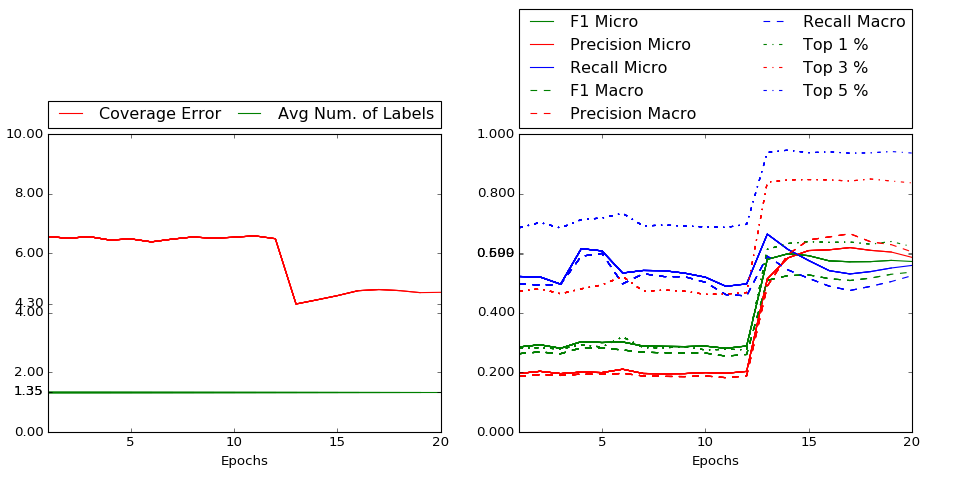

doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.001
Epoch 01: Coverage Error -> 6.56
Epoch 02: Coverage Error -> 6.51
Epoch 03: Coverage Error -> 6.56
Epoch 04: Coverage Error -> 6.45
Epoch 05: Coverage Error -> 6.49
Epoch 06: Coverage Error -> 6.39
Epoch 07: Coverage Error -> 6.48
Epoch 08: Coverage Error -> 6.55
Epoch 09: Coverage Error -> 6.51
Epoch 10: Coverage Error -> 6.54
Epoch 11: Coverage Error -> 6.59
Epoch 12: Coverage Error -> 6.50
Epoch 13: Coverage Error -> 4.30
Epoch 14: Coverage Error -> 4.44
Epoch 15: Coverage Error -> 4.58
Epoch 16: Coverage Error -> 4.75
Epoch 17: Coverage Error -> 4.79
Epoch 18: Coverage Error -> 4.75
Epoch 19: Coverage Error -> 4.68
Epoch 20: Coverage Error -> 4.69


In [32]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break

In [119]:
[metric['coverage_error'] for metric in epoch_metrics]

[6.0518029456576938,
 4.3138649060436771,
 3.7851701371254443,
 1.4565769426104622,
 1.3819197562214323]